INFO: Loading burst configuration from: /arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation/configs/bursts/chromatica_dsa.yaml
INFO: Loading telescope configuration from: /arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation/configs/bursts/../telescopes/dsa.yaml
INFO: Configurations successfully loaded and merged.
INFO: Intermediate results will be cached in: /arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation/data/cache
INFO: --- Starting Scintillation Pipeline for chromatica ---
INFO: Loading cached processed spectrum from /arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation/data/cache/chromatica_processed_spectrum.pkl
INFO: Locating burst and defining analysis windows...
INFO: Finding full signal envelope with S/N threshold > 5.0 (downsample ×8).
INFO: Applying 200.0% padding (4 downsampled bins) to each side.
INFO: Full signal envelope found between bins 1216 and 130

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
--- Loaded Configuration ---
{
  "telescope_name": "DSA-110",
  "instrument_type": "Multi-Dish Interferometer",
  "native_channel_width_mhz": 0.03051757812,
  "total_bandwidth_mhz": 187.5,
  "num_channels": 6144,
  "min_freq_mhz": 1311.25,
  "max_freq_mhz": 1498.75,
  "burst_id": "chromatica",
  "input_data_path": "/arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation/data/chromatica.npz",
  "telescope": "dsa",
  "analysis": {
    "rfi_masking": {
      "find_burst_thres": 5.0,
      "padding_factor": 2.0,
      "use_symmetric_noise_window": true,
      "rfi_downsample_factor": 16,
      "enable_time_domain_flagging": false,
      "time_threshold_sigma": 7.0,
      "freq_threshold_sigma": 5.0
    },
    "acf": {
      "num_subbands": 4,
      "max_lag_mhz": 45.0,
      "use_snr_subbanding": true
    },
    "fitting": {
      "fit_lagrange_mhz": 45.0,
      "reference_freq

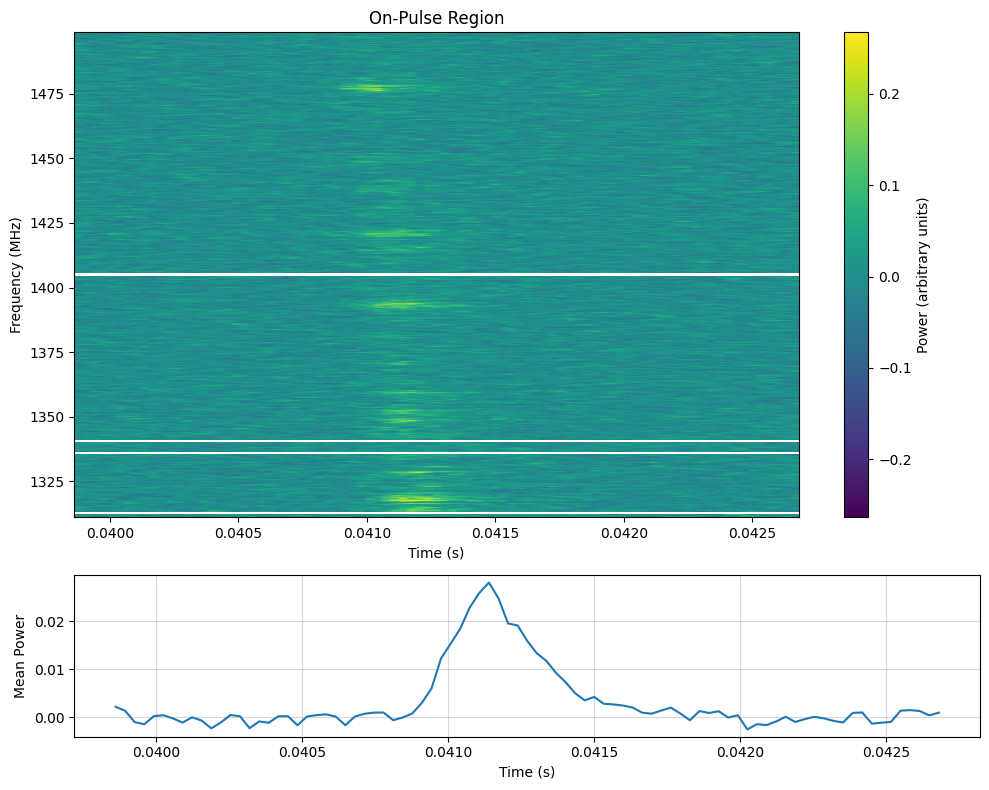

INFO: Initializing DynamicSpectrum object.
INFO: Spectrum shape: (6144, 1016)


<Figure size 640x480 with 0 Axes>

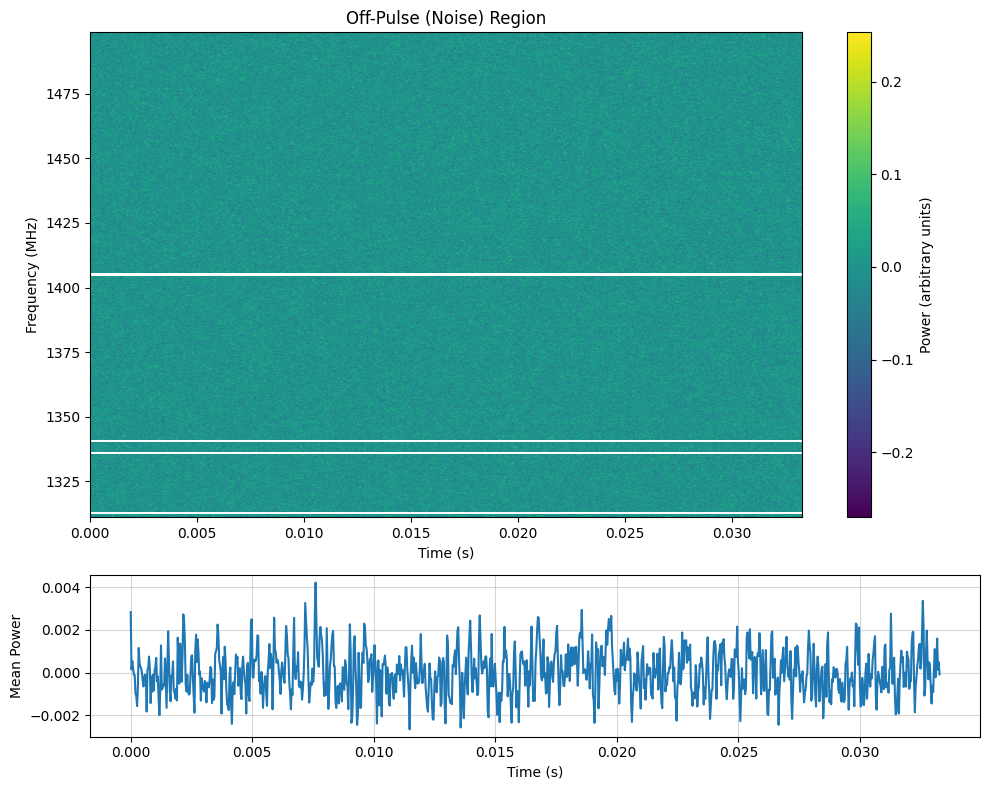

INFO: Diagnostic plots saved to: /arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation/plots/diagnostics
INFO: Characterizing off-pulse noise...
/arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation/scint_analysis/noise.py:145: UserWarning: NaNs detected – in‑painting with row/col medians.
  warnings.warn("NaNs detected – in‑painting with row/col medians.")
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1095: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
INFO: Noise characterization complete. Detected kind: 'flux_shiftedgamma'
INFO: Loading cached ACF results from /arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation/data/cache/chromatica_acf_results.pkl
INFO: Fitting models and deriving final scintillation parameters...
INFO: Fitting all ACF models to all sub-band ACFs...
/opt/pysetup/.venv/lib/python3.8/site-p

--- Pipeline Execution Finished ---

--- Generating Final Analysis Plot ---
Saved plots to: /arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation/plots/chromatica_analysis_overview.png


INFO: Analysis overview plot saved to: /arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation/plots/chromatica_analysis_overview.png


<Figure size 640x480 with 0 Axes>

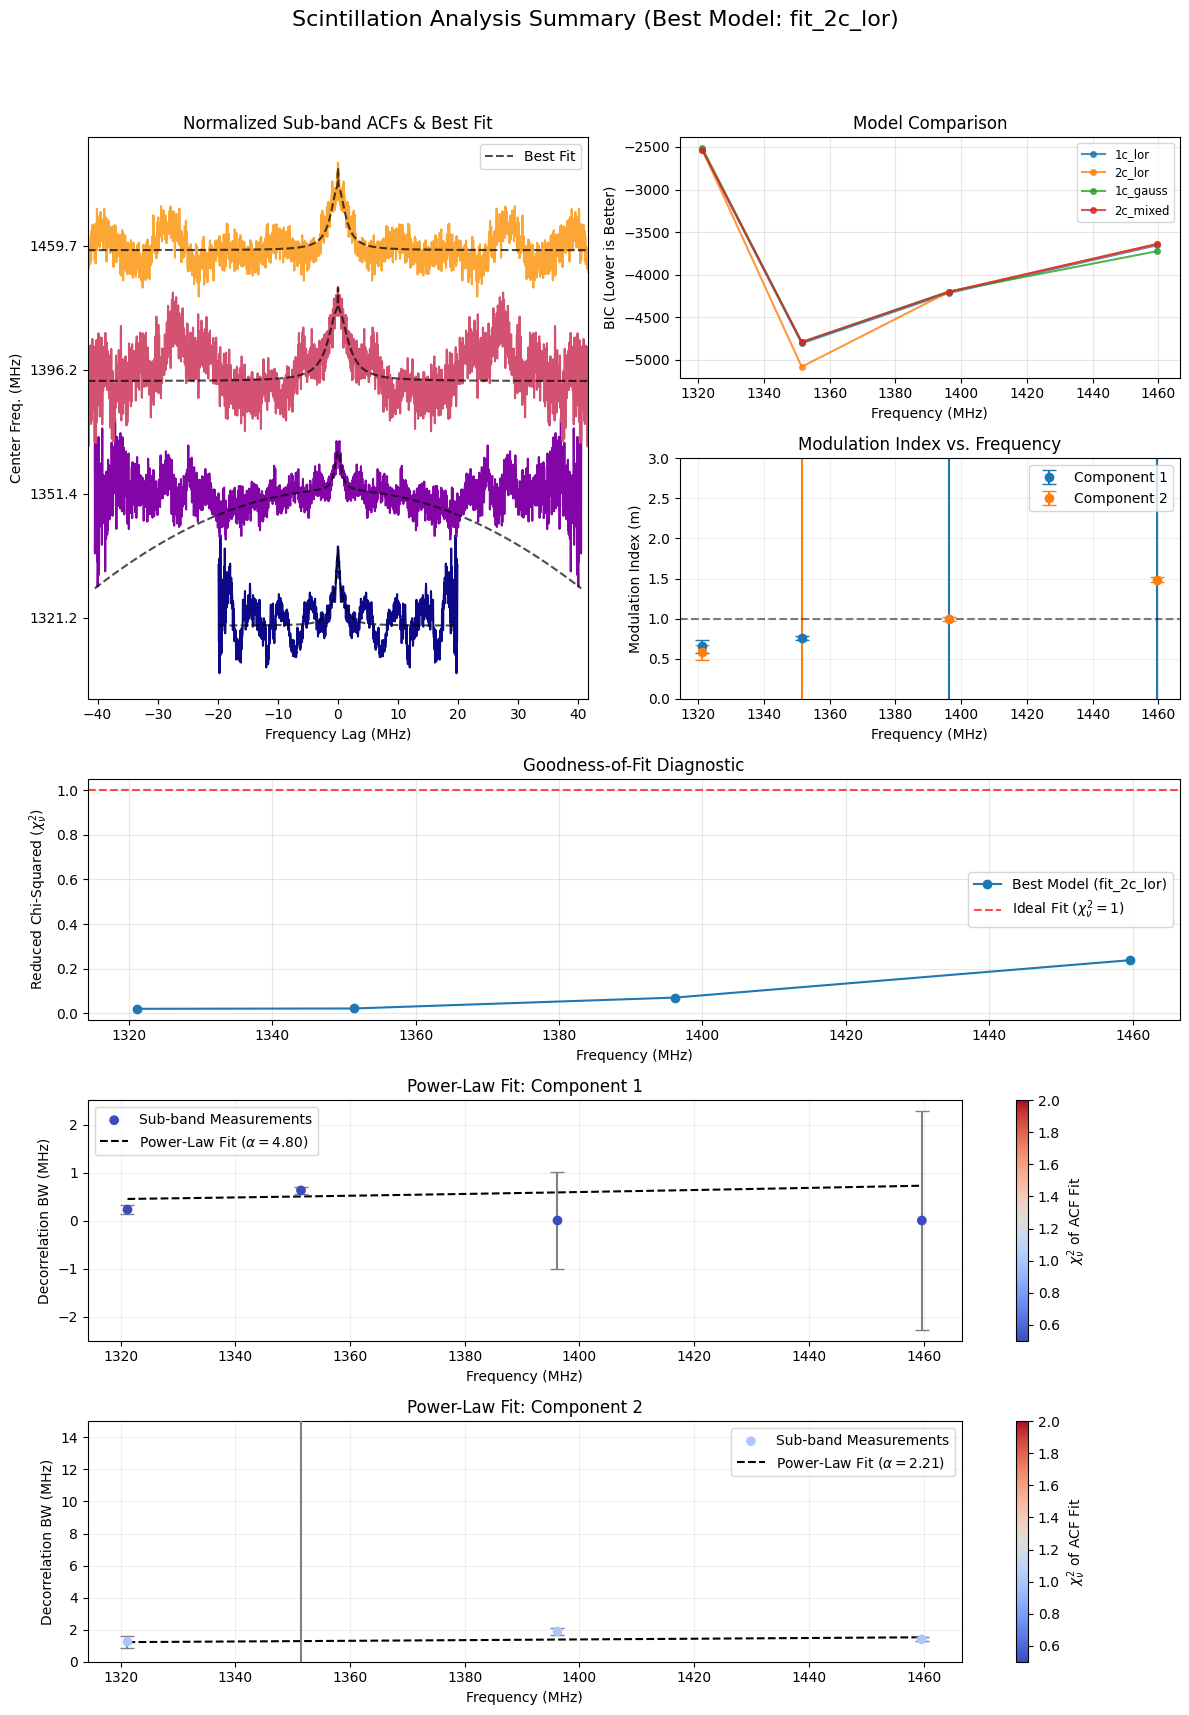

In [6]:
# Set path for module imports
import sys
# replace the path below with the absolute path to your `scattering/` folder
pkg_root = "/arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation"
sys.path.insert(0, pkg_root)

%load_ext autoreload
%autoreload 2

import json
import logging
import numpy as np
import matplotlib.pyplot as plt

# Import the main pipeline components
from scint_analysis import config, pipeline, plotting
# Import your new noise model if you need to use it separately
# from scint_analysis import noise_model 

# --- 1. Configuration ---
# Set up basic logging to see pipeline output in the notebook
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

# Define the path to the configuration file for the analysis run
BURST_CONFIG_PATH = '/arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation/configs/bursts/chromatica_dsa.yaml'

# Load the merged configuration from the YAML files
try:
    analysis_config = config.load_config(BURST_CONFIG_PATH)
    print("--- Loaded Configuration ---")
    print(json.dumps(analysis_config, indent=2))
except Exception as e:
    logging.error(f"Failed to load configuration: {e}")
    # Stop execution if config fails
    raise

# --- 2. Initialize and Run the Pipeline ---
print("\n--- Initializing and Running Scintillation Pipeline ---")
# Create an instance of the main pipeline controller
scint_pipeline = pipeline.ScintillationAnalysis(analysis_config)

# This single .run() call executes all the steps in the correct order:
# - Loads and masks data
# - Characterizes off-pulse noise (NEW)
# - Calculates ACFs using the noise model for normalization
# - Fits all models and derives final parameters
scint_pipeline.run()
print("--- Pipeline Execution Finished ---")


# --- 3. Save and Plot Results ---

# Save the final parameters to a JSON file
if scint_pipeline.final_results:
    output_json_path = f"./{analysis_config.get('burst_id', 'output')}_analysis_results.json"
    # Note: You may need your NumpyJSONEncoder class if results contain numpy types
    with open(output_json_path, 'w') as f:
        json.dump(scint_pipeline.final_results, f, indent=4)
    logging.info(f"Final results saved to {output_json_path}")

# Generate the final overview plot using the results stored in the pipeline object
print("\n--- Generating Final Analysis Plot ---")
if scint_pipeline.final_results and scint_pipeline.all_subband_fits:
    # Get the plot save path from the config, as we implemented
    save_path = analysis_config.get('pipeline_options', {}).get('output_plot_path')
    print(f'Saved plots to: {save_path}')
    
    plotting.plot_analysis_overview(
        analysis_results=scint_pipeline.final_results,
        acf_results=scint_pipeline.acf_results,
        all_subband_fits=scint_pipeline.all_subband_fits,
        all_powerlaw_fits=scint_pipeline.all_powerlaw_fits,
        save_path=save_path
    )
else:
    logging.warning("Pipeline did not produce final results, skipping plot.")

In [89]:
# Set path for module imports
import sys, os
# replace the path below with the absolute path to your `scattering/` folder
pkg_root = "/arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation"
sys.path.insert(0, pkg_root)

%load_ext autoreload
%autoreload 2

import logging
import json
import importlib
import numpy as np

import matplotlib.pyplot as plt

# Import all modules from our new package

from scint_analysis import config
from scint_analysis import core
from scint_analysis import analysis
from scint_analysis import plotting
from scint_analysis import noise

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


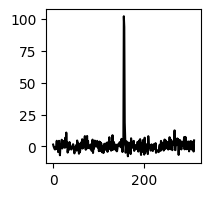

INFO: Loading burst configuration from: /arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation/configs/bursts/chromatica.yaml
ERROR: Burst config file not found: /arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation/configs/bursts/chromatica.yaml
ERROR: Failed to load configuration: [Errno 2] No such file or directory: '/arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation/configs/bursts/chromatica.yaml'
INFO: Loading DynamicSpectrum from file: /arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/dsa110-scat/scintillation/scint_analysis/data/chromatica.npz
INFO: Initializing DynamicSpectrum object.
INFO: Spectrum shape: (6144, 2500)
INFO: Generating dynamic spectrum plot.


Raw spectrum loaded successfully.
<DynamicSpectrum (6144 channels x 2500 timesteps, 1311.2-1498.8 MHz)>

Displaying raw dynamic spectrum...


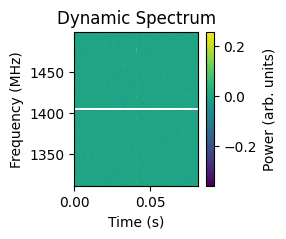

INFO: Applying RFI masking.
INFO: Using time downsampling factor of 16 for RFI statistical checks.
INFO: Finding full signal envelope with S/N threshold > 5.0 (downsample ×8).
INFO: Full signal envelope found between bins 1248 and 1271.
INFO: Using symmetric noise window of duration 23 bins.
INFO: Using downsampled noise statistics from bins 76 to 78.



Applying RFI masking...


Iterative RFI Masking in Frequency Domain:  20%|██        | 1/5 [00:00<00:00, 95.87it/s]
INFO: Masked 4 channels based on frequency-domain stats.
INFO: Skipping time-domain RFI flagging as per configuration.
INFO: Initializing DynamicSpectrum object.
INFO: Spectrum shape: (6144, 2500)
INFO: Generating dynamic spectrum plot.


RFI masking complete.

Displaying RFI-masked dynamic spectrum...


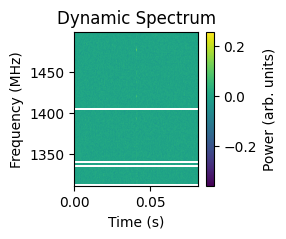

INFO: Starting sub-band ACF calculations.
INFO: Finding full signal envelope with S/N threshold > 5.0 (downsample ×8).
INFO: Full signal envelope found between bins 1248 and 1271.



Calculating ACFs for all sub-bands (this may take a moment)...


Calculating sub-band ACFs: 100%|██████████| 4/4 [00:00<00:00, 45.73it/s]
INFO: Fitting all ACF models to all sub-band ACFs...


ACF calculation complete.

ACF Results Dictionary Keys: dict_keys(['subband_acfs', 'subband_lags_mhz', 'subband_center_freqs_mhz', 'subband_channel_widths_mhz', 'subband_num_channels'])
Computed ACFs for 4 sub-bands.

Fitting models and deriving final scintillation parameters...


/opt/pysetup/.venv/lib/python3.8/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
INFO: --- Model Comparison (Lowest Total BIC is Best) ---
INFO: Model 'fit_1c_lor': Total BIC = -15596.96 (from 4 fits)
INFO: Model 'fit_2c_lor': Total BIC = -15823.69 (from 4 fits)
INFO: Model 'fit_1c_gauss': Total BIC = -15614.35 (from 4 fits)
INFO: Model 'fit_2c_gauss': Total BIC = -15969.15 (from 4 fits)
INFO: ==> Best overall model selected: fit_2c_gauss
INFO: Generating full analysis overview plot.


Analysis complete.

--- Final Derived Parameters ---
{
  "best_model": "fit_2c_gauss",
  "components": {
    "component_1": {
      "power_law_fit_report": [
        1.2424166370458382e-15,
        4.656596743308591
      ],
      "scaling_index": 4.656596743308591,
      "scaling_index_err": 19.389891332427776,
      "bw_at_ref_mhz": 0.5552861268834482,
      "bw_at_ref_mhz_err": 0.5027122692995908,
      "subband_measurements": [
        {
          "freq_mhz": 1321.2766563568289,
          "bw": 0.2166188597177501,
          "mod": 0.5799089118204033,
          "bw_err": 0.05011815789291532,
          "finite_err": 0.01125696560810462
        },
        {
          "freq_mhz": 1351.8907699820936,
          "bw": 0.7116981035811853,
          "mod": 0.7130434710031897,
          "bw_err": 0.053624932548932684,
          "finite_err": 0.04683610909245623
        },
        {
          "freq_mhz": 1396.6062998534917,
          "bw": 0.912487430812929,
          "mod": 0.718646542814878

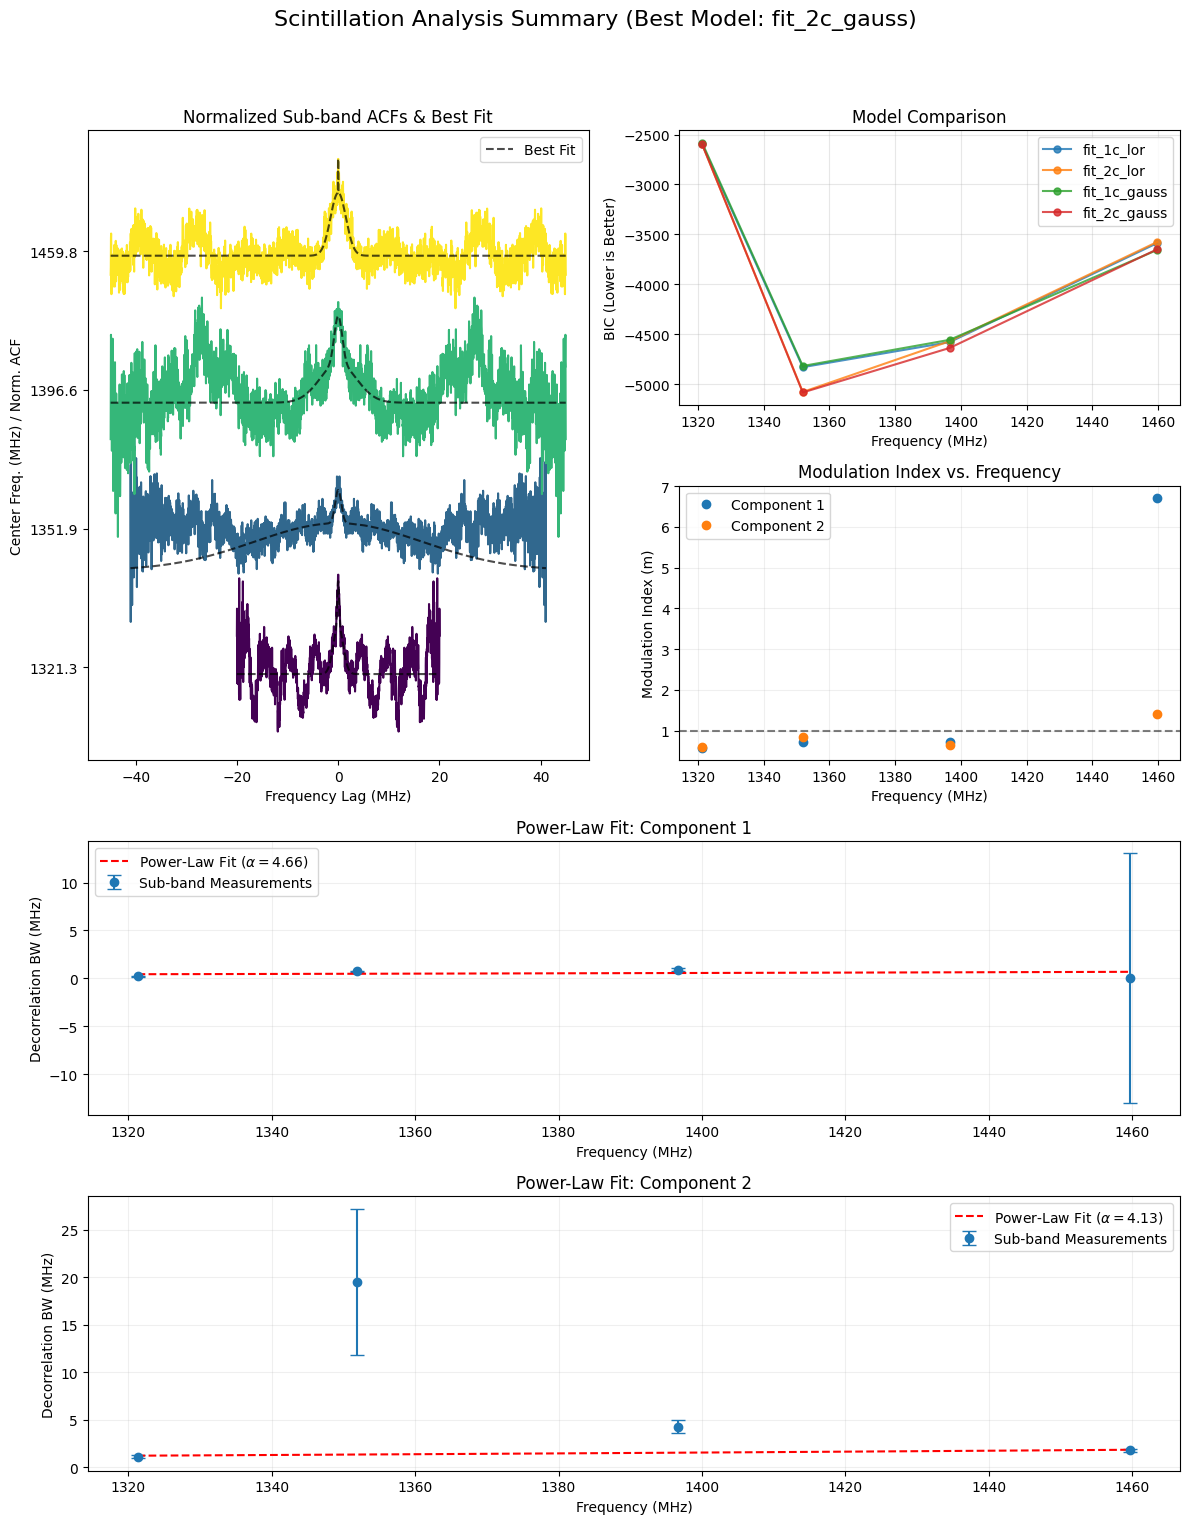

In [90]:
# --- Configuration ---
# Set up basic logging to see pipeline output in the notebook
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

# Define the path to the configuration file for the analysis run
BURST_CONFIG_PATH = '/arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation/configs/bursts/chromatica.yaml'

casey = np.load('/arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation/data/chromatica_dsa_I_272_368_2500b_cntr_bpc.npy')
downsample_factor = 8
prof = np.nansum(casey,axis=0)
n = prof.size - (prof.size % downsample_factor)
prof = prof[:n].reshape(-1, downsample_factor).mean(axis=1)
    
fig = plt.figure(figsize = (2, 2))
plt.plot(prof, c ='k')
plt.show()

# Load the merged configuration from the YAML files
try:
    analysis_config = config.load_config(BURST_CONFIG_PATH)
    # Pretty-print the configuration to verify it
    print("--- Loaded Configuration ---")
    print(json.dumps(analysis_config, indent=2))
except Exception as e:
    logging.error(f"Failed to load configuration: {e}")

# Load the dynamic spectrum from the path specified in the config
try:
    raw_spectrum = core.DynamicSpectrum.from_numpy_file(analysis_config['input_data_path'])
    print("Raw spectrum loaded successfully.")
    print(raw_spectrum)
except Exception as e:
    logging.error(f"Failed to load data: {e}")

# --- Visualization Step 1: Inspect Raw Data ---
if 'raw_spectrum' in locals():
    print("\nDisplaying raw dynamic spectrum...")
    plotting.plot_dynamic_spectrum(raw_spectrum, figsize=(2, 2))

# --- Perform RFI Masking ---
if 'raw_spectrum' in locals():
    print("\nApplying RFI masking...")
    masked_spectrum = raw_spectrum.mask_rfi(analysis_config)
    print("RFI masking complete.")

    # --- Visualization Step 2: Inspect Masked Data ---
    print("\nDisplaying RFI-masked dynamic spectrum...")
    plotting.plot_dynamic_spectrum(masked_spectrum, figsize=(2, 2))

# --- Calculate ACFs for all sub-bands ---
if 'masked_spectrum' in locals():
    print("\nCalculating ACFs for all sub-bands (this may take a moment)...")
    acf_results = analysis.calculate_acfs_for_subbands(masked_spectrum, analysis_config)
    print("ACF calculation complete.")
    
    # You can inspect the structure of the results
    print("\nACF Results Dictionary Keys:", acf_results.keys())
    print(f"Computed ACFs for {len(acf_results['subband_acfs'])} sub-bands.")
    
# --- Run the final analysis and fitting stage ---
if 'acf_results' in locals() and acf_results['subband_acfs']:
    print("\nFitting models and deriving final scintillation parameters...")
    # This function returns both the final parameters and the raw lmfit objects
    final_results, all_subband_fits, powlaw_fit_params = analysis.analyze_scintillation_from_acfs(acf_results, analysis_config)
    print("Analysis complete.")

    # --- Inspect the Final Results ---
    print("\n--- Final Derived Parameters ---")
    print(json.dumps(final_results, indent=2))
else:
    logging.error("ACF results not available. Cannot proceed to final analysis.")
    
# --- Generate the final overview plot ---
if 'final_results' in locals() and 'all_subband_fits' in locals():
    print("\nGenerating final analysis overview plot...")
    plotting.plot_analysis_overview(
        filename='../casey_dsa_scint.pdf',
        analysis_results=final_results,
        acf_results=acf_results,
        all_subband_fits=all_subband_fits,
        powlaw_fit_params=powlaw_fit_params
    )
else:
    logging.warning("Final results not available, skipping overview plot.")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation/scint_analysis/noise.py:145: UserWarning: NaNs detected – in‑painting with row/col medians.
  warnings.warn("NaNs detected – in‑painting with row/col medians.")


Descriptor OK – nan‑safe.  Fake spectrum mean: 0.9932773


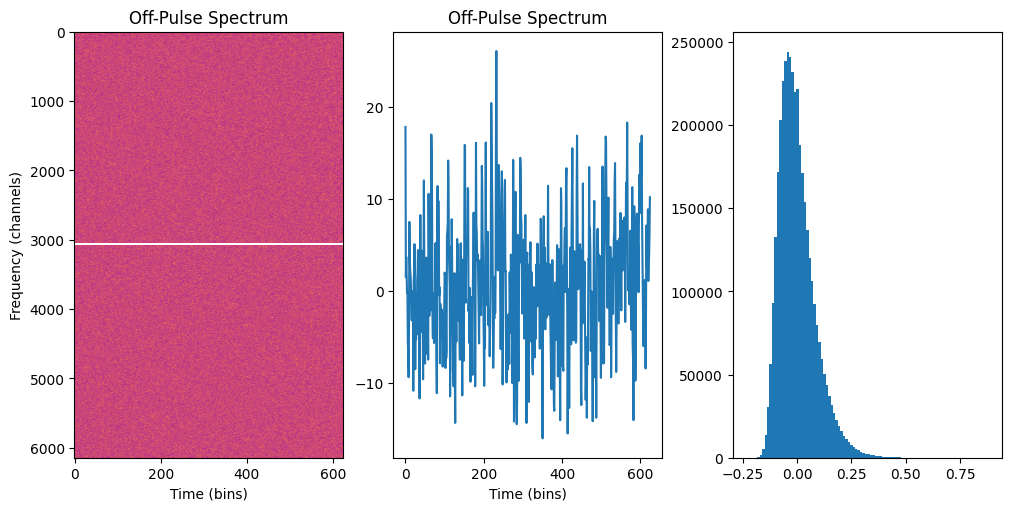

Nan check: (array([], dtype=int64), array([], dtype=int64))


/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1095: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


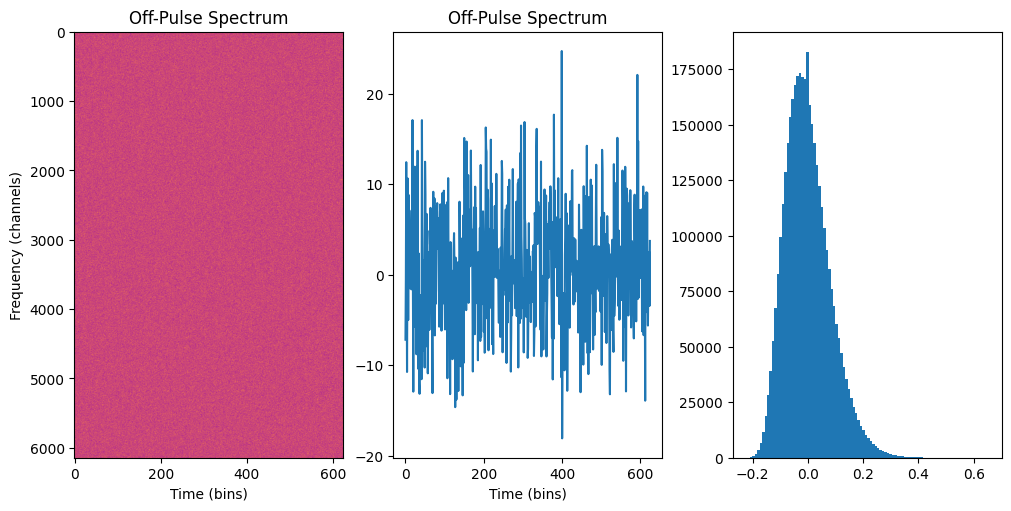

In [91]:
# Set path for module imports
import sys, os
# replace the path below with the absolute path to your `scattering/` folder
pkg_root = "/arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation"
sys.path.insert(0, pkg_root)

%load_ext autoreload
%autoreload 2

from scint_analysis.noise import NoiseDescriptor, estimate_noise_descriptor

rng = np.random.default_rng(0)
I_syn = rng.exponential(scale=1.0, size=(2048, 64)).astype(np.float32)
# Inject NaNs to test robustness
I_syn[100:110, 10:20] = np.nan
desc = estimate_noise_descriptor(I_syn)
fake = desc.sample(seed=1)
print("Descriptor OK – nan‑safe.  Fake spectrum mean:", fake.mean())

#################################################################################
#################################################################################

power = raw_spectrum.power
off_pulse = power[:, :power.shape[1]//4]

fig, axes = plt.subplots(1, 3, figsize=(10, 5), constrained_layout=True)
ax = axes.ravel()
mean=np.nanmean(off_pulse)
std=np.nanstd(off_pulse)
ax[0].imshow(off_pulse, aspect='auto', cmap='plasma', vmin=mean-3*std, vmax=mean+3*std)
ax[0].set_title('Off-Pulse Spectrum')
ax[0].set_xlabel('Time (bins)')
ax[0].set_ylabel('Frequency (channels)')

ax[1].plot(np.nansum(off_pulse,axis=0))
ax[1].set_title('Off-Pulse Spectrum')
ax[1].set_xlabel('Time (bins)')

ax[2].hist(off_pulse.flatten(), bins=100)

plt.show()

print(f'Nan check: {np.where(off_pulse == np.nan)}')
desc = estimate_noise_descriptor(off_pulse)
off_pulse_fake = desc.sample(seed=123)

fig, axes = plt.subplots(1, 3, figsize=(10, 5), constrained_layout=True)

ax = axes.ravel()
mean_fake=np.nanmean(off_pulse_fake)
std_fake=np.nanstd(off_pulse_fake)
ax[0].imshow(off_pulse_fake, aspect='auto', cmap='plasma', vmin=mean_fake-3*std_fake, vmax=mean_fake+3*std_fake)
ax[0].set_title('Off-Pulse Spectrum')
ax[0].set_xlabel('Time (bins)')
ax[0].set_ylabel('Frequency (channels)')

ax[1].plot(np.nansum(off_pulse_fake,axis=0))
ax[1].set_title('Off-Pulse Spectrum')
ax[1].set_xlabel('Time (bins)')

ax[2].hist(off_pulse_fake.flatten(), bins=100)

plt.show()



In [75]:
print(off_pulse.min(), off_pulse.max(), off_pulse.mean())
print(off_pulse_fake.min(), off_pulse_fake.max(), off_pulse_fake.mean())

-0.24012995953556518 0.8857529960977865 0.0001013889272447105
0.0 1.0263812e-14 3.3833236e-21


In [83]:
print(off_pulse_fake)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


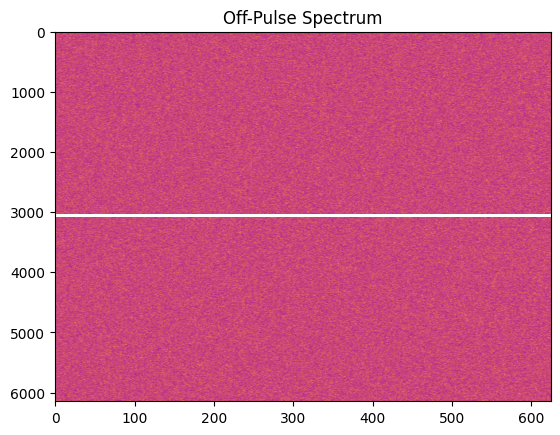

In [17]:
# Generate fake noise

#rng = np.random.default_rng(0)
#I = rng.exponential(scale=1.0, size=(2048, 64)).astype(np.float32)
#
#fig=plt.figure()
#plt.hist(I.flatten(), bins=100)
#plt.title('Noise Histogram')
#plt.show()
#
#fig=plt.figure()
#mean=np.nanmean(I)
#std=np.nanstd(I)
#plt.imshow(I, aspect='auto', cmap='plasma', vmin=mean-3*std, vmax=mean+3*std)
#plt.title('Noise Spectrum')
#plt.show()
#
#desc = estimate_noise_descriptor(I)
#print("Recovered descriptor:\n", desc)
#
#fake = desc.sample(seed=1)
#print("Fake spectrum shape:", fake.shape)
#
#fig=plt.figure()
#mean=np.nanmean(fake)
#std=np.nanstd(fake)
#plt.imshow(fake, aspect='auto', cmap='plasma', vmin=mean-3*std, vmax=mean+3*std)
#plt.title('Fake Noise Spectrum')
#plt.show()




In [6]:
# Import all modules from our new package
import scint_analysis
importlib.reload(scint_analysis)
from scint_analysis import config, core, analysis, plotting

# --- Run the final analysis and fitting stage ---
if 'acf_results' in locals() and acf_results['subband_acfs']:
    print("\nFitting models and deriving final scintillation parameters...")
    # This function returns both the final parameters and the raw lmfit objects
    final_results, all_subband_fits, powlaw_fit_params = analysis.analyze_scintillation_from_acfs(acf_results, analysis_config)
    print("Analysis complete.")

    # --- Inspect the Final Results ---
    print("\n--- Final Derived Parameters ---")
    print(json.dumps(final_results, indent=2))
else:
    logging.error("ACF results not available. Cannot proceed to final analysis.")


INFO: Fitting Lorentzian models to all sub-band ACFs...
/opt/pysetup/.venv/lib/python3.8/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")



Fitting models and deriving final scintillation parameters...


INFO: Model selection complete. Best overall model: 1 component(s).


Analysis complete.

--- Final Derived Parameters ---
{
  "best_model": 1,
  "components": {
    "scint_scale": {
      "power_law_fit_report": [
        2.010124792228405e-09,
        2.8364871387202912
      ],
      "scaling_index": 2.8364871387202912,
      "scaling_index_err": 19.183037981321714,
      "bw_at_ref_mhz": 1.6872317140451365,
      "bw_at_ref_mhz_err": 0.8493381502928066,
      "subband_measurements": [
        {
          "freq_mhz": 1324.4815236854959,
          "bw": 2.302610996664314,
          "mod": 0.3977613801984734,
          "bw_err": 0.12556720679626796,
          "finite_err": 0.33941468231261723
        },
        {
          "freq_mhz": 1365.2901676705194,
          "bw": 12.721848432969393,
          "mod": 1.140616544032408,
          "bw_err": 0.0768978557125016,
          "finite_err": 3.055808106466236
        },
        {
          "freq_mhz": 1410.829806283575,
          "bw": 1.348577332124393,
          "mod": 0.24526926969015905,
          "bw_e

INFO: Generating full analysis overview plot.



Generating final analysis overview plot...


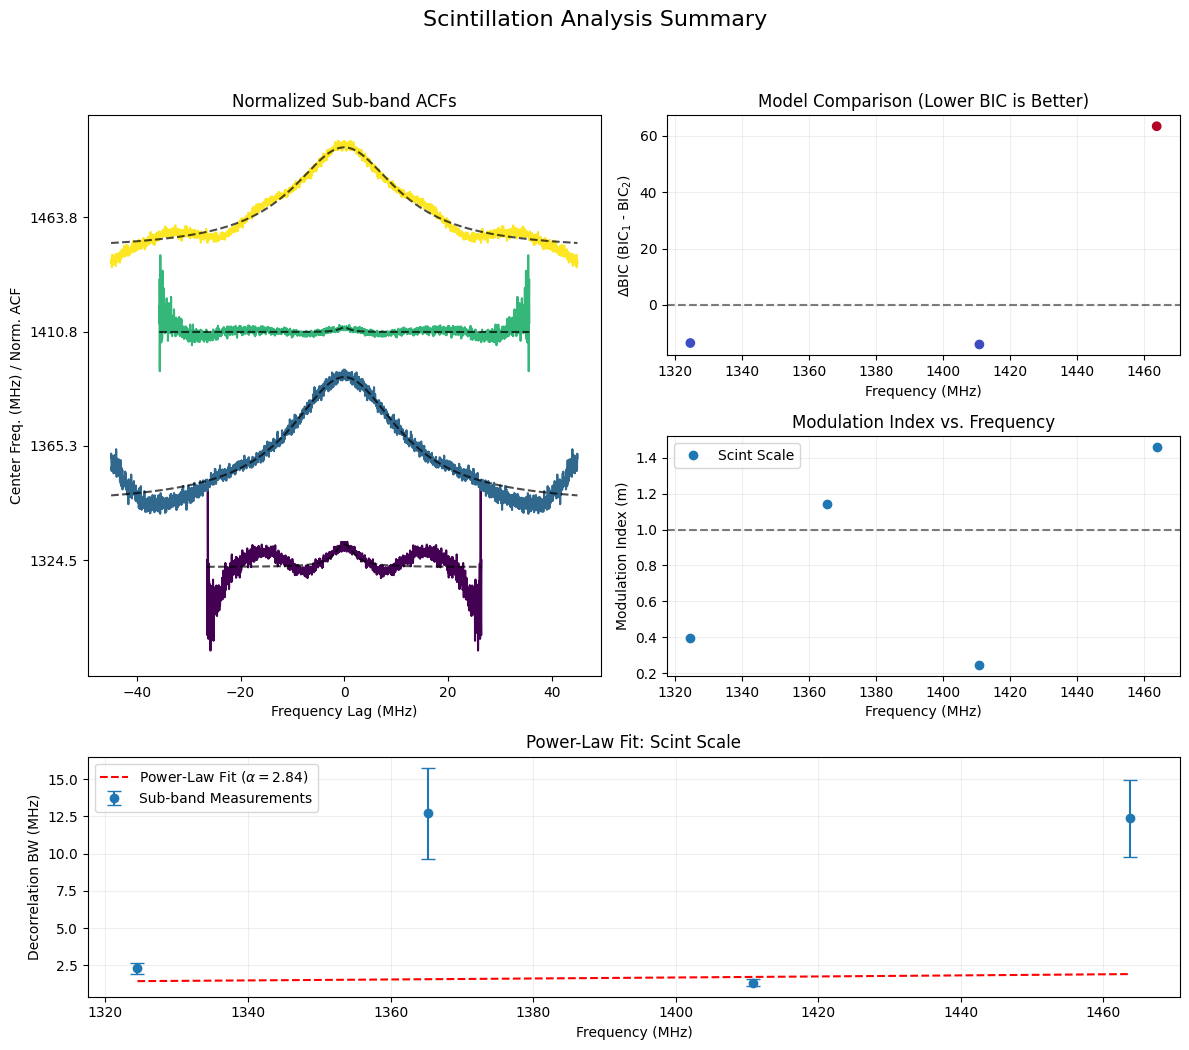

In [11]:
# Import all modules from our new package
import scint_analysis
importlib.reload(scint_analysis)
from scint_analysis import config, core, analysis, plotting
importlib.reload(config)
importlib.reload(core)
importlib.reload(analysis)
importlib.reload(plotting)

# --- Generate the final overview plot ---
if 'final_results' in locals() and 'all_subband_fits' in locals():
    print("\nGenerating final analysis overview plot...")
    plotting.plot_analysis_overview(
        analysis_results=final_results,
        acf_results=acf_results,
        all_subband_fits=all_subband_fits,
        powlaw_fit_params=powlaw_fit_params
    )
else:
    logging.warning("Final results not available, skipping overview plot.")
